<a href="https://colab.research.google.com/github/iamkevinxavier/humber-AdvDL-midterm/blob/main/Assignment03_lkhm0039.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


## Downloading and loading CIFAR 10 Data


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 30812324.40it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
trainset.data.shape

(50000, 32, 32, 3)

 # Normalizing, reshaping and parsing to tenso

In [ ]:
data =trainset.data
dataN = data / np.max(data)
dataT = dataN.reshape(50000, 3, 32, 32)
dataT = torch.tensor( dataT, dtype = torch.float32)
dataT.shape


torch.Size([50000, 3, 32, 32])

Use Falttened Image to convert 4d Image data to 2D
Flatten the image batch (50000, 3, 32, 32) to (50000, 3*32*32)
(batch_size, channels, height, width) -> (batch_size, channels * height * width)


In [ ]:
#Reshape the data from (50000, 3, 32, 32) to (50000, 3072)
#dataT = dataT.reshape(50000, -1) # Flatten each image to a vector of size 3*32*32 = 3072

#print(f"Reshaped data shape: {dataT.shape}")  # Should print (50000, 3072)

#Convert the reshaped data to a PyTorch tensor
#dataT_tensor = torch.tensor(dataT, dtype=torch.float32)  # Converting to PyTorch tensor
#dataT_tensor.shape


# Create Variational Autoencoder Class

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()


        # Encoder layers
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2_mu = nn.Linear(512, 128)  # Latent mean
        self.fc2_logvar = nn.Linear(512, 128)  # Latent variance
        # Decoder layers
        self.fc3 = nn.Linear(128, 512)
        self.fc4 = nn.Linear(512, 32*32*3)


    def encoder(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc2_mu(h1)
        logvar = self.fc2_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)  # Random normal noise
        return mu + eps * std  # Reparameterization trick

    def decoder(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encoder(x.view(-1, 32*32*3))
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


# Create a loss function

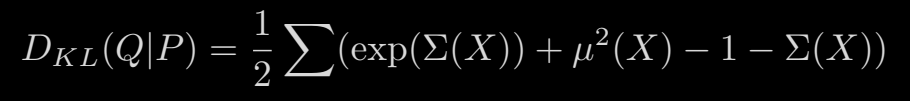

In [ ]:
def loss_func(reconstructed_image, original_image, mu, logvar):
    # Reshape the reconstructed image to match the original image shape
    reconstructed_image = reconstructed_image.view(-1, *original_image.shape[1:]) # Reshape to match original image dimensions

    BCE = F.binary_cross_entropy(reconstructed_image, original_image, reduction='sum')
    DKL = -0.5 * torch.sum(-logvar.exp() - mu.pow(2) + 1 + logvar)
    return BCE + DKL

# We are using BCE loss since our target or original image is normalized between 0 and 1.
# reduction = 'sum' means we want to sum the output loss.

# Check GPU

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Create Model Instance and set optimizer

In [ ]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
model

VAE(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2_mu): Linear(in_features=512, out_features=128, bias=True)
  (fc2_logvar): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3072, bias=True)
)

# Train the model

In [ ]:
epochs = 41001

losses = torch.zeros(epochs)

for epoch in range(epochs):

  # Selecting a batchsize  of 32.

  random_idx = np.random.choice(dataT.shape[0], size=32)

  X = dataT[random_idx,:].to(device)
  predicted, mu, logvar = model(X)
  loss = loss_func(predicted, X, mu, logvar)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  losses[epoch] = loss.item()

  if (epoch % 1000) == 0:
      print(f' epochs : {epoch}  loss : {loss : 2.2f}')



 epochs : 0  loss :  68899.66
 epochs : 1000  loss :  60073.56
 epochs : 2000  loss :  59827.38
 epochs : 3000  loss :  58615.01
 epochs : 4000  loss :  58487.14
 epochs : 5000  loss :  58323.88
 epochs : 6000  loss :  61249.06
 epochs : 7000  loss :  58882.35
 epochs : 8000  loss :  56761.29
 epochs : 9000  loss :  61113.25
 epochs : 10000  loss :  58071.59
 epochs : 11000  loss :  59208.10
 epochs : 12000  loss :  57787.51
 epochs : 13000  loss :  56781.90
 epochs : 14000  loss :  57790.24
 epochs : 15000  loss :  59485.75
 epochs : 16000  loss :  58245.87
 epochs : 17000  loss :  59061.71
 epochs : 18000  loss :  57756.77
 epochs : 19000  loss :  58166.92
 epochs : 20000  loss :  58094.82
 epochs : 21000  loss :  59938.66
 epochs : 22000  loss :  59079.44
 epochs : 23000  loss :  58972.13
 epochs : 24000  loss :  59738.00
 epochs : 25000  loss :  59379.70
 epochs : 26000  loss :  59802.58
 epochs : 27000  loss :  59596.65
 epochs : 28000  loss :  60304.29
 epochs : 29000  loss :  56

# Performance Visualization

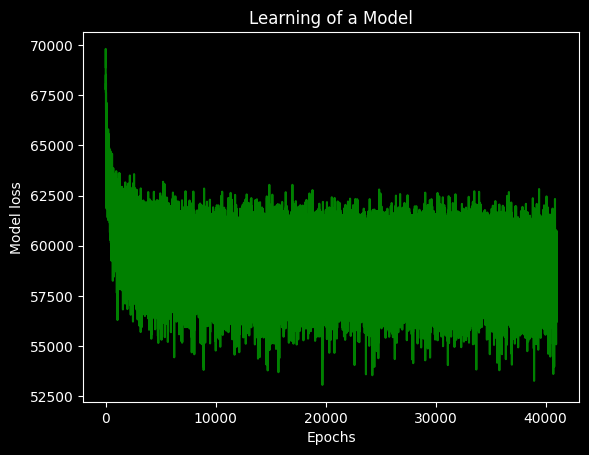

In [ ]:
plt.plot(losses, color = 'g', ls = '-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('Learning of a Model')
plt.show()

# Model Testing

In [ ]:
X = dataT[:7,:]  # Extracting first seven samples
model = model.cpu()
ypred, mu, logvar = model(X)

In [ ]:
ypred.shape

torch.Size([7, 3072])

# Visualizing Model Performance

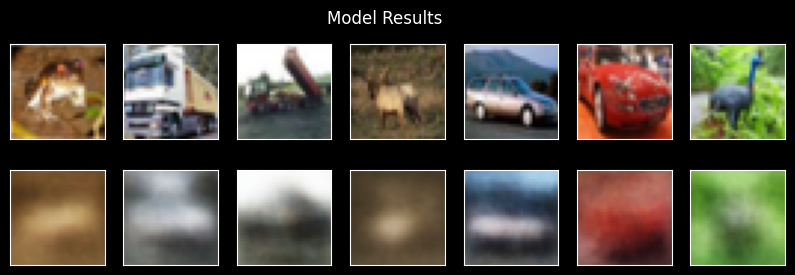

In [ ]:
fig,axes = plt.subplots(2,7,figsize=(10,3))

for i in range(7):
  axes[0,i].imshow(X[i,:].view(32,32,3).detach().cpu() ,cmap='gray')
  axes[1,i].imshow(ypred[i,:].view(32,32,3).detach().cpu() ,cmap='gray')
  axes[0,i].set_xticks([]), axes[0,i].set_yticks([])
  axes[1,i].set_xticks([]), axes[1,i].set_yticks([])

plt.suptitle('Model Results')
plt.show()

## Generating 7 samples from Gaussian Distribution of size equal to latent layer size i.e 50

In [ ]:
sample = torch.randn(7,128)

# Pass the samples to decoder

In [ ]:
y_pred = model.decoder(sample)

# Visualize the decoder performance on randomly generated samples

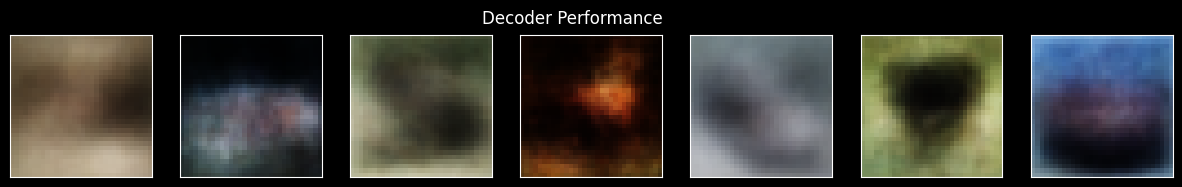

In [ ]:
fig,axes = plt.subplots(1,7,figsize=(15,2))

for i in range(7):
  axes[i].imshow(y_pred[i,:].view(32,32,3).detach() ,cmap='gray')
  axes[i].set_xticks([]), axes[i].set_yticks([])
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.suptitle('Decoder Performance')
plt.show()

# Understanding reduction = 'sum' in BCE Loss

In [ ]:
input = torch.randn(3, 2, requires_grad=True)
>>> target = torch.rand(3, 2, requires_grad=False)
>>> loss = F.binary_cross_entropy(torch.sigmoid(input), target)
>>> loss.backward()

In [ ]:
target

In [ ]:
torch.sigmoid(input)

In [ ]:
loss

In [ ]:
loss = F.binary_cross_entropy(torch.sigmoid(input), target, reduction = 'sum')
loss